### THIS IS ANOTHER MODEL THAT I HAVE CREATED BUT IT HAD AN ACCURACY OF ONLY 55 %, I HAVE TRIED TO USE LOGISTIC REGRESSION AND OTHER SUCH MODELS, BUT FOUND OUT THE PROBLEM IN MY ORIGINAL CODE, SO MY ACCURACY CLIMBED UP TO 85%.

Importing Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns

Data Loading

In [2]:
# I start by setting up the paths to my dataset directories. 
# The dataset is organized into 'train','test' and 'val' directories, 
# with subdirectories 'NORMAL' and 'PNEUMONIA' for each class.
# train_dir = 'F:\pneumonia\chest_xray\train'
# test_dir = 'F:\pneumonia\chest_xray\test'
# val_dir = 'F:\pneumonia\chest_xray\val'
#This did not work, so I made it into a raw string literal

# Corrected paths with raw string literals
train_dir = r'F:\pneumonia\chest_xray\train'
test_dir = r'F:\pneumonia\chest_xray\test'
val_dir = r'F:\pneumonia\chest_xray\val'

# Verify directory existence
print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))
print("Test directory contents:", os.listdir(val_dir))

Train directory contents: ['NORMAL', 'PNEUMONIA']
Test directory contents: ['NORMAL', 'PNEUMONIA']
Test directory contents: ['NORMAL', 'PNEUMONIA']


DATA PROCESSING AND AUGMENTATION

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


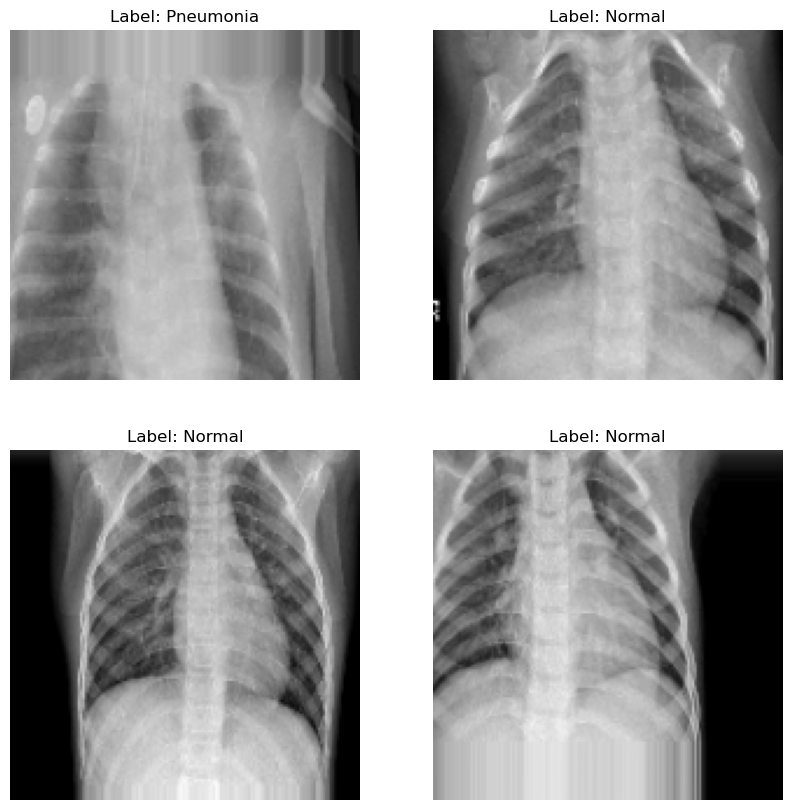

In [3]:
# I use ImageDataGenerator for data preprocessing. This will help with normalization and augmentation.
# First, I define an instance for training data which includes augmentation.
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing pixel values to the range [0, 1]
    width_shift_range=0.2,  # Randomly translate images horizontally
    height_shift_range=0.2,  # Randomly translate images vertically
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Randomly zoom into images
    fill_mode ='nearest'  # Fill in missing pixels with the nearest value
)
#https://www.geeksforgeeks.org/python-data-augmentation/

# I define another ImageDataGenerator instance for validation data. 
# Since I don’t need augmentation for validation data, I just rescale the pixel values.
test_datagen = ImageDataGenerator(rescale=1./255)

# I create a data generator for training data using the defined augmentation settings.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='binary'  # Binary classification (pneumonia vs. normal)
)

# I create a data generator for test data. No augmentation, only rescaling.
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='binary'  # Binary classification (pneumonia vs. normal)
)

# To ensure everything is set up correctly, I visualized a few images from the training set.
# First, I get a batch of images and labels.
images, labels = next(train_generator)

# Plotting the first 4 images from the batch to check if augmentation is working correctly.
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {"Pneumonia" if labels[i] == 1 else "Normal"}')
    plt.axis('off')
plt.show()

# The above code helps me verify that my data preprocessing and augmentation pipeline is functioning as expected.


Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.


https://www.datacamp.com/tutorial/complete-guide-data-augmentation

In [4]:
# Initialize the model
model = Sequential()

# Add convolutional layers with activation functions
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to feed into fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to check the architecture
model.summary()


c:\Users\Tanish Reddy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of batches per epoch
    epochs=10,  # Number of epochs to train the model
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size  # Number of validation batches
)


Epoch 1/10


c:\Users\Tanish Reddy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7256 - loss: 0.5757 - val_accuracy: 0.7993 - val_loss: 0.4919
Epoch 2/10


c:\Users\Tanish Reddy\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2588
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8753 - loss: 0.2830 - val_accuracy: 0.8141 - val_loss: 0.4175
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2434
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 541s 3s/step - accuracy: 0.8868 - loss: 0.2713 - val_accuracy: 0.8536 - val_loss: 0.4269
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0427
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8909 - loss: 0.2559 - val_accuracy: 0.8602 - val_loss: 0.3663
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2509
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.8966 - loss: 

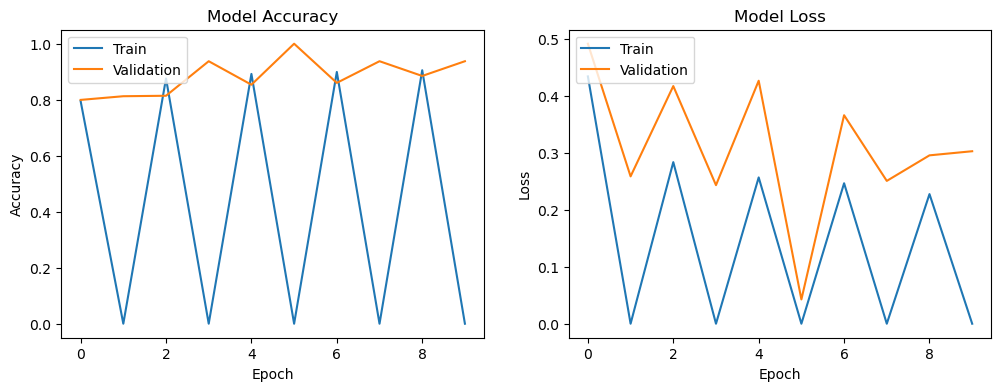

In [6]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 556ms/step


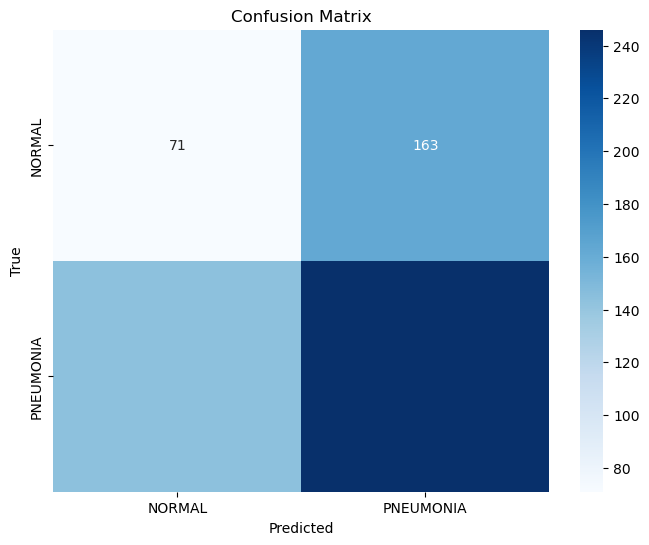

              precision    recall  f1-score   support

      NORMAL       0.33      0.30      0.32       234
   PNEUMONIA       0.60      0.63      0.62       390

    accuracy                           0.51       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.50      0.51      0.50       624



In [7]:
# import seaborn as sns

# # Predict classes for the test set
# y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
# y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class labels

# # Get true labels
# y_true = test_generator.classes

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred_classes)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=test_generator.class_indices.keys(), 
#             yticklabels=test_generator.class_indices.keys())
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Print classification report
# print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))



# Predict classes for the entire test set
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Flatten the array to match the shape of y_true

# Get true labels
y_true = test_generator.classes

# Ensure predictions and true labels have the same length
assert len(y_true) == len(y_pred_classes), "Mismatch between number of true labels and predictions."

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))



In [8]:
# Save the model
model.save('pneumonia_detection_model.h5')


In [9]:
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes)
print(f'F1 Score: {f1:.2f}')

Accuracy: 50.80%
F1 Score: 0.62


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_logistic_regression_model(input_shape=(150, 150, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Logistic regression is for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

logistic_regression_model = create_logistic_regression_model()
logistic_regression_model.summary()


c:\Users\Tanish Reddy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def create_continuous_regression_model(input_shape=(150, 150, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression (single continuous value)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

continuous_regression_model = create_continuous_regression_model()
continuous_regression_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)